# Lab 6: Bayesian Regression
## *Bayesian Treatment of Linear Regression*


### Based on Neil D. Lawrence MLAI2015 version 
### Modified by Haiping Lu on 27 October 2018

### Note by Haiping
- The first person in this notebook refers to Neil D. Lawrence rather than Haiping Lu.
- Headings marked as (<span style="color:red">*optional*</span>) are background info for your interest, which can be safely skipped if you would like to be more focused on the core and have less interest in the background.
- Related session: you are suggested to review the materials in Session 3.

$$\newcommand{\inputScalar}{x}
\newcommand{\lengthScale}{\ell}
\newcommand{\mappingVector}{\mathbf{w}}
\newcommand{\gaussianDist}[3]{\mathcal{N}\left(#1|#2,#3\right)}
\newcommand{\gaussianSamp}[2]{\mathcal{N}\left(#1,#2\right)}
\newcommand{\zerosVector}{\mathbf{0}}
\newcommand{\eye}{\mathbf{I}}
\newcommand{\dataStd}{\sigma}
\newcommand{\dataScalar}{y}
\newcommand{\dataVector}{\mathbf{y}}
\newcommand{\dataMatrix}{\mathbf{Y}}
\newcommand{\noiseScalar}{\epsilon}
\newcommand{\noiseVector}{\mathbf{\epsilon}}
\newcommand{\noiseMatrix}{\mathbf{\Epsilon}}
\newcommand{\inputVector}{\mathbf{x}}
\newcommand{\kernelMatrix}{\mathbf{K}}
\newcommand{\basisMatrix}{\mathbf{\Phi}}
\newcommand{\basisVector}{\mathbf{\phi}}
\newcommand{\basisScalar}{\phi}
\newcommand{\expSamp}[1]{\left<#1\right>}
\newcommand{\expDist}[2]{\left<#1\right>_{#2}}
\newcommand{\covarianceMatrix}{\mathbf{C}}
\newcommand{\numData}{n}
\newcommand{\mappingScalar}{w}
\newcommand{\mappingFunctionScalar}{f}
\newcommand{\mappingFunctionVector}{\mathbf{f}}
\newcommand{\meanVector}{\boldsymbol{\mu}}
\newcommand{\meanScalar}{\mu}$$

### Overdetermined Systems (<span style="color:red">*optional*</span>)

In **Session 3**, we motivated the introduction of probability by considering systems where there were more observations than unknowns. In particular we thought about the simple fitting of the gradient and an offset of a line, i.e., linear regression

$$ y= mx +c $$

and what happens if we have three pairs of observations of $x$ and $y$, $\{x_i, y_i\}_{i=1}^3$. We solved this issue by introducing a type of [slack variable](http://en.wikipedia.org/wiki/Slack_variable), $\epsilon_i$, known as noise, such that for each observation we had the equation,

$$y_i = mx_i + c + \epsilon_i.$$

### Underdetermined System (<span style="color:red">*optional*</span>)

In contrast, today we'd like to consider the situation where you have more parameters than data in your simultaneous equation. So we have an *underdetermined* system. In fact this set up is in some sense *easier* to solve, because we don't need to think about introducing a slack variable (although it might make a lot of sense from a *modelling* perspective to do so).

In the overdetermined system, we resolved the problem by introducing slack variables, $\epsilon_i$, which needed to be estimated for each point. The slack variable represented the difference between our actual prediction and the true observation. This is known as the *residual*. By introducing the slack variable we now have an additional $n$ variables to estimate, one for each data point, $\{\epsilon_i\}$. This actually turns the overdetermined system into an underdetermined system. Introduction of $n$ variables, plus the original $m$ and $c$ gives us $n+2$ parameters to be estimated from $n$ observations, which actually makes the system *underdetermined*. However, we then made a probabilistic assumption about the slack variables, we assumed that the slack variables were distributed according to a probability density. And for the moment we have been assuming that density was the Gaussian,

$$\epsilon_i \sim \mathcal{N}(0, \sigma^2),$$

with zero mean and variance $\sigma^2$. 

#### Sum of Squares and Probability

In the overdetermined system we introduced a new set of slack variables, $\{\epsilon_i\}_{i=1}^n$, on top of our parameters $m$ and $c$. We dealt with the variables by placing a probability distribution over them. This gives rise to the likelihood and for the case of Gaussian distributed variables, it gives rise to the sum of squares error. It was Gauss who first made this connection in his volume on "Theoria Motus Corprum Coelestium" (written in Latin)

In [63]:
import pods
pods.notebook.display_google_book(id='ORUOAAAAQAAJ', page='213')

The relevant section roughly translates as

... It is clear, that for the product $\Omega = h^\mu \pi ^{-frac{1}{2}\mu} e^{-hh(vv + v^\prime v^\prime + v^{\prime\prime} v^{\prime\prime} + \dots)}$ to be maximised the sum $vv + v ^\prime v^\prime + v^{\prime\prime} v^{\prime\prime} + \text{etc}.$ ought to be minimized. *Therefore, the most probable values of the unknown quantities $p , q, r , s \text{etc}.$, should be that in which the sum of the squares of the differences between the functions $V, V^\prime, V^{\prime\prime} \text{etc}$, and the observed values is minimized*, for all observations of the same degree of precision is presumed.

It's on the strength of this paragraph that the density is known as the Gaussian, despite the fact that four pages later Gauss credits the necessary integral for the density to Laplace, and it was also Laplace that did a lot of the original work on dealing with these errors through probability. [Stephen Stigler's book on the measurement of uncertainty before 1900](http://www.hup.harvard.edu/catalog.php?isbn=9780674403413) has a nice chapter on this.

In [64]:
pods.notebook.display_google_book(id='ORUOAAAAQAAJ', page='217')

where the crediting to the Laplace is about halfway through the last paragraph. This book was published in 1809, four years after [Legendre presented least squares](./week3.ipynb) in an appendix to one of his chapters on the orbit of comets. Gauss goes on to make a claim for priority on the method on page 221 (towards the end of the first paragraph ...).

In [65]:
pods.notebook.display_google_book(id='ORUOAAAAQAAJ', page='221')

## A Philosophical Dispute: Probabilistic Treatment of Parameters? (<span style="color:red">*optional*</span>)

The follow up question is whether we can do the same thing with the parameters. If we have two parameters and only one unknown can we place a probability distribution over the parameters, as we did with the slack variables? The answer is yes, and from a philosophical perspective placing a probability distribution over the *parameters* is known as the *Bayesian* approach. This is because Thomas Bayes, in a [1763 essay](http://en.wikipedia.org/wiki/An_Essay_towards_solving_a_Problem_in_the_Doctrine_of_Chances) published at the Royal Society introduced the [Bernoulli distribution](http://en.wikipedia.org/wiki/Bernoulli_distribution) with a probabilistic interpretation for the *parameters*. Later statisticians such as [Ronald Fisher](http://en.wikipedia.org/wiki/Ronald_Fisher) objected to the use of probability distributions for *parameters*, and so in an effort to discredit the approach the referred to it as Bayesian. However, the earliest practioners of modelling, such as Laplace applied the approach as the most natural thing to do for dealing with unknowns (whether they were parameters or variables). Unfortunately, this dispute led to a split in the modelling community that still has echoes today. It is known as the Bayesian vs Frequentist controversy. From my own perspective, I think that it is a false dichotomy, and that the two approaches are actually complementary. My own research focus is on *modelling* and in that context, the use of probability is vital. For frequenstist statisticians, such as Fisher, the emphasis was on the value of the **evidence** in the data for a particular **hypothesis**. This is known as **hypothesis testing**. The two approaches can be unified because one of the most important approaches to hypothesis testing is to [compute the ratio of the likelihoods](http://en.wikipedia.org/wiki/Likelihood-ratio_test), and the result of applying a probability distribution to the parameters is merely to arrive at a different form of the **likelihood**.

## The Bayesian Approach

The aim of this notebook is to study Bayesian approaches to regression. In the Bayesian approach we define a *prior* density over our parameters, $m$ and $c$ or more generally $\mathbf{w}$. This prior distribution gives us a range of expected values for our parameter *before* we have seen the data. The objective in Bayesian inference is to then compute the *posterior* density which is the effect on the density of having observed the data. In standard probability notation we write the prior distribution as,
$$p(\mathbf{w}),$$
so it is the *marginal* distribution for the parameters, i.e. the distribution we have for the parameters without any knowledge about the data. The posterior distribution is written as,
$$p(\mathbf{w}|\mathbf{y}, \mathbf{X}).$$
So the posterior distribution is the *conditional* distribution for the parameters given the data (which in this case consists of pairs of observations including response variables (or targets), $y_i$, and covariates (or inputs) $\mathbf{x}_i$, where we are allowing the inputs to be multivariate. 

The posterior is recovered from the prior using *Bayes' rule*. Which is simply a rewriting of the product rule. We can recover Bayes rule as follows. The product rule of probability tells us that the joint distribution is given as the product of the conditional and the marginal. Dropping the inputs from our conditioning for the moment we have,
$$p(\mathbf{w}, \mathbf{y})=p(\mathbf{y}|\mathbf{w})p(\mathbf{w}),$$
where we see we have related the joint density to the prior density and the *likelihood* from our previous investigation of regression,
$$p(\mathbf{y}|\mathbf{w}) = \prod_{i=1}^n\mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i, \sigma^2)$$
which arises from the assumption that our observation is given by
$$y_i = \mathbf{w}^\top \mathbf{x}_i + \epsilon_i.$$
In other words this is the Gaussian likelihood we have been fitting by minimizing the sum of squares. Have a look at Session 3 notebook as a reminder.

We've introduce the likelihood, but we don't have  relationship with the posterior, however, the product rule can also be written in the following way
$$p(\mathbf{w}, \mathbf{y}) = p(\mathbf{w}|\mathbf{y})p(\mathbf{y}),$$
where here we have simply used the opposite conditioning. We've already introduced the *posterior* density above. This is the density that represents our belief about the parameters *after* observing the data. This is combined with the *marginal likelihood*, sometimes also known as the evidence. It is the marginal likelihood, because it is the original likelihood of the data with the parameters marginalised, $p(\mathbf{y})$. Here it's conditioned on nothing, but in practice you should always remember that everything here is conditioned on things like model choice: which set of basis functions. Because it's a regression problem, its also conditioned on the inputs. Using the equality between the two different forms of the joint density  we recover
$$p(\mathbf{w}|\mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{w})p(\mathbf{w})}{p(\mathbf{y})}$$
where we divided both sides by $p(\mathbf{y})$ to recover this result. Let's re-introduce the conditioning on the input locations (or covariates), $\mathbf{X}$ to write the full form of Bayes' rule for the regression problem. 
$$p(\mathbf{w}|\mathbf{y}, \mathbf{X}) = \frac{p(\mathbf{y}|\mathbf{w}, \mathbf{X})p(\mathbf{w})}{p(\mathbf{y}|\mathbf{X})}$$
where the posterior density for the parameters given the data is $p(\mathbf{w}|\mathbf{y}, \mathbf{X})$, the marginal likelihood is $p(\mathbf{y}|\mathbf{X})$, the prior density is $p(\mathbf{w})$ and our original regression likelihood is given by $p(\mathbf{y}|\mathbf{w}, \mathbf{X})$. It turns out that to compute the posterior the only things we need to do are define the prior and the likelihood. The other term on the right hand side can be computed by *the sum rule*. It is one of the key equations of Bayesian inference, the expectation of the likelihood under the prior, this process is known as marginalisation,
$$
p(\mathbf{y}|\mathbf{X}) = \int p(\mathbf{y}|\mathbf{w},\mathbf{X})p(\mathbf{w}) \text{d}\mathbf{w}
$$
I like the term marginalisation, and the description of the probability as the *marginal likelihood*, because (for me) it somewhat has the implication that the variable name has been removed, and (perhaps) written in the margin. Marginalisation of a variable goes from a likelihood where the variable is in place, to a new likelihood where **all possible values** of that variable (under the prior) have been **considered and weighted** in the integral. 

This implies that all we need for specifying our model is to define the likelihood and the prior. We already have our likelihood from our earlier discussion, so our focus now turns to the prior density.



### The Bayesian Controversy: Philosophical Underpinnings (<span style="color:red">*optional*</span>)

A segment from the lecture in 2012 on philsophical underpinnings.

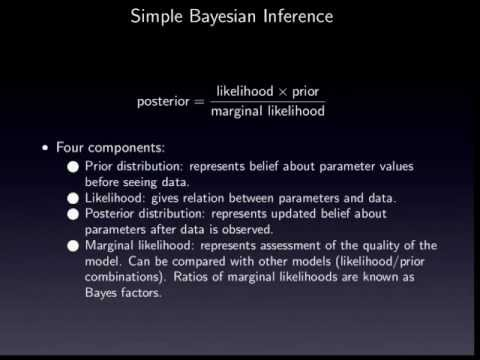

In [4]:
from datetime import timedelta
start=int(timedelta(hours=0, minutes=20, seconds=15).total_seconds())
from IPython.display import YouTubeVideo
YouTubeVideo('AvlnFnvFw_0',start=start)

## The Prior Density

Let's assume that the prior density is given by a zero mean Gaussian, which is independent across each of the parameters, 
$$\mappingVector \sim \gaussianSamp{\zerosVector}{\alpha \eye}$$
In other words, we are assuming, for the prior, that each element of the parameters vector, $\mappingScalar_i$, was drawn from a Gaussian density as follows
$$\mappingScalar_i \sim \gaussianSamp{0}{\alpha}$$

Let's start by assigning the parameter of the prior distribution, which is the variance of the prior distribution, $\alpha$.

In [66]:
# set prior variance on w
alpha = 4.
# set the order of the polynomial basis set
order = 5
# set the noise variance
sigma2 = 0.01

### Generating from the Model

A very important aspect of probabilistic modelling is to *sample* from your model to see what type of assumptions you are making about your data. In this case that involves a two stage process.

1. Sample a candiate parameter vector from the prior.
2. Place the candidate parameter vector in the likelihood and sample functions conditiond on that candidate vector.
3. Repeat to try and characterise the type of functions you are generating.

Given a prior variance (as defined above) we can now  sample from the prior distribution and combine with a basis set to see what assumptions we are making about the functions *a priori* (i.e. before we've seen the data). 

Firstly we compute the basis function matrix. We will do it both for our training data, and for a range of prediction locations (`x_pred`). 

In [67]:
import numpy as np
data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']
num_data = x.shape[0]
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = np.linspace(1890, 2016, num_pred_data)[:, None] # input locations for predictions
print(x)
print(x_pred)

[[1896.]
 [1900.]
 [1904.]
 [1908.]
 [1912.]
 [1920.]
 [1924.]
 [1928.]
 [1932.]
 [1936.]
 [1948.]
 [1952.]
 [1956.]
 [1960.]
 [1964.]
 [1968.]
 [1972.]
 [1976.]
 [1980.]
 [1984.]
 [1988.]
 [1992.]
 [1996.]
 [2000.]
 [2004.]
 [2008.]
 [2012.]]
[[1890.        ]
 [1891.27272727]
 [1892.54545455]
 [1893.81818182]
 [1895.09090909]
 [1896.36363636]
 [1897.63636364]
 [1898.90909091]
 [1900.18181818]
 [1901.45454545]
 [1902.72727273]
 [1904.        ]
 [1905.27272727]
 [1906.54545455]
 [1907.81818182]
 [1909.09090909]
 [1910.36363636]
 [1911.63636364]
 [1912.90909091]
 [1914.18181818]
 [1915.45454545]
 [1916.72727273]
 [1918.        ]
 [1919.27272727]
 [1920.54545455]
 [1921.81818182]
 [1923.09090909]
 [1924.36363636]
 [1925.63636364]
 [1926.90909091]
 [1928.18181818]
 [1929.45454545]
 [1930.72727273]
 [1932.        ]
 [1933.27272727]
 [1934.54545455]
 [1935.81818182]
 [1937.09090909]
 [1938.36363636]
 [1939.63636364]
 [1940.90909091]
 [1942.18181818]
 [1943.45454545]
 [1944.72727273]
 [1946. 

now let's build the basis matrices. We define the polynomial basis as follows.

In [68]:
def polynomial(x, degree, loc, scale):
    degrees = np.arange(degree+1)
    return ((x-loc)/scale)**degrees

In [69]:
loc = 1950.
scale = 1.
degree = 5. 
Phi_pred = polynomial(x_pred, degree=degree, loc=loc, scale=scale)
Phi = polynomial(x, degree=degree, loc=loc, scale=scale)


## Sampling from the Prior

Now we will sample from the prior to produce a vector $\mappingVector$ and use it to plot a function which is representative of our belief *before* we fit the data. To do this we are going to use the properties of the Gaussian density and obtain a sample from a *standard normal* using the function `np.random.normal`.

### Scaling Gaussian-distributed Variables

First, let's consider the case where we have one data point and one feature in our basis set. In otherwords $\mappingFunctionVector$ would be a scalar, $\mappingVector$ would be a scalar and $\basisMatrix$ would be a scalar. In this case we have 

$$\mappingFunctionScalar = \basisScalar \mappingScalar$$

If $\mappingScalar$ is drawn from a normal density, 

$$\mappingScalar \sim \gaussianSamp{\meanScalar_\mappingScalar}{c_\mappingScalar}$$

and $\basisScalar$ is a scalar value which we are given, then properties of the Gaussian density tell us that 

$$\basisScalar \mappingScalar \sim \gaussianSamp{\basisScalar\meanScalar_\mappingScalar}{\basisScalar^2c_\mappingScalar}$$

Let's test this out numerically. First we will draw 200 samples from a standard normal,

In [70]:
w_vec = np.random.normal(size=200)

We can compute the mean of these samples and their variance

In [71]:
print('w sample mean is ', w_vec.mean())
print('w sample variance is ', w_vec.var())

w sample mean is  -0.12283178362198775
w sample variance is  1.0986236968726348


These are close to zero (the mean) and one (the variance) as you'd expect. Now compute the mean and variance of the scaled version,

In [72]:
phi = 7
f_vec = phi*w_vec
print('True mean should be phi*0 = 0.')
print('True variance should be phi*phi*1 = ', phi*phi)
print('f sample mean is ', f_vec.mean())
print('f sample variance is ', f_vec.var())

True mean should be phi*0 = 0.
True variance should be phi*phi*1 =  49
f sample mean is  -0.8598224853539144
f sample variance is  53.832561146759105


If you increase the number of samples then you will see that the sample mean and the sample variance begin to converge towards the true mean and the true variance. Obviously adding an offset to a sample from `np.random.normal` will change the mean. So if you want to sample from a Gaussian with mean `mu` and standard deviation `sigma` one way of doing it is to sample from the standard normal and scale and shift the result, so to sample a set of $\mappingScalar$ from a Gaussian with mean $\meanScalar$ and variance $\alpha$,

$$w \sim \gaussianSamp{\meanScalar}{\alpha}$$

We can simply scale and offset samples from the *standard normal*.

In [73]:
mu = 4 # mean of the distribution
alpha = 2 # variance of the distribution
w_vec = np.random.normal(size=200)*np.sqrt(alpha) + mu
print('w sample mean is ', w_vec.mean())
print('w sample variance is ', w_vec.var())

w sample mean is  4.0440414286768736
w sample variance is  2.1800606045803805


Here the `np.sqrt` is necesssary because we need to multiply by the standard deviation and we specified the variance as `alpha`. So scaling and offsetting a Gaussian distributed variable keeps the variable Gaussian, but it effects the mean and variance of the resulting variable. 

To get an idea of the overal shape of the resulting distribution, let's do the same thing with a histogram of the results. 

C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


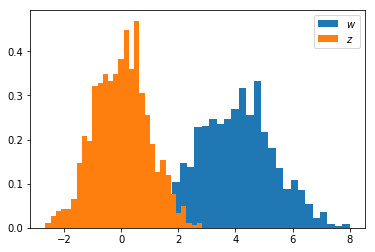

In [74]:
# First the standard normal
import matplotlib.pyplot as plt
%matplotlib inline
z_vec = np.random.normal(size=1000) # by convention, in statistics, z is often used to denote samples from the standard normal
w_vec = z_vec*np.sqrt(alpha) + mu
# plot normalized histogram of w, and then normalized histogram of z on top
plt.hist(w_vec, bins=30, normed=True)
plt.hist(z_vec, bins=30, normed=True)
plt.legend(('$w$', '$z$'))

Now **re-run** this histogram with 100,000 samples and check that the both histograms look qualitatively Gaussian.

## Sampling from the Prior

Let's use this way of constructing samples from a Gaussian to check what functions look like *a priori*. The process will be as follows. First, we sample a random vector of $K$ dimensional from `np.random.normal`. Then we scale it by $\sqrt{\alpha}$ to obtain a prior sample of $\mappingVector$.  

In [75]:
K = int(degree) + 1
z_vec = np.random.normal(size=K)
w_sample = z_vec*np.sqrt(alpha)
print(w_sample)

[-1.36203834 -2.61213065  0.84834126 -1.87155261 -4.41482077 -0.19681898]


Now we can combine our sample from the prior with the basis functions to create a function,

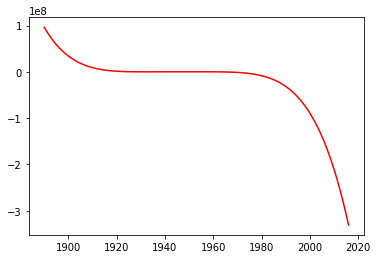

In [76]:
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')

This shows the recurring problem with the polynomial basis. Our prior allows relatively large coefficients for the basis associated with high polynomial degrees. Because we are operating with input values of around 2000, this leads to output functions of very high values. The fix we have used for this before is to rescale our data before we apply the polynomial basis to it. Above, we set the scale of the basis to 1. Here let's set it to 100 and try again.

In [77]:
scale = 100.
Phi_pred = polynomial(x_pred, degree=degree, loc=loc, scale=scale)
Phi = polynomial(x, degree=degree, loc=loc, scale=scale)

Now we need to recompute the basis functions from above, 

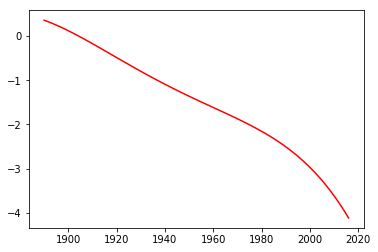

In [78]:
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')

Now let's loop through some samples and plot various functions as samples from this system,

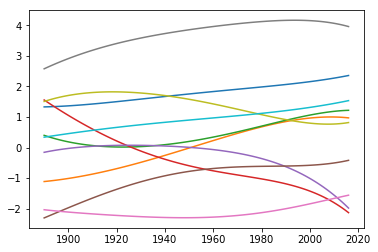

In [79]:
num_samples = 10
K = int(degree)+1
for i in range(num_samples):
    z_vec = np.random.normal(size=K)
    w_sample = z_vec*np.sqrt(alpha)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())


The predictions for the mean output can now be computed. We want the expected value of the predictions under the posterior distribution. In matrix form, the predictions can be computed as

$$\mathbf{f} = \basisMatrix \mappingVector.$$

This involves a matrix multiplication between a fixed matrix $\basisMatrix$ and a vector $\mappingVector$ that is drawn from a distribution. Because $\mappingVector$ is drawn from a distribution, this imples that $\mappingFunctionVector$ should also be drawn from a distribution. There are two distributions we are interested in though. We have just been sampling from the *prior* distribution to see what sort of functions we get *before* looking at the data. In Bayesian inference, we need to compute the *posterior* distribution and sample from that density.

### Bayesian Inference
The process of Bayesian inference involves combining the prior, $p(\mappingVector)$ with the likelihood, $p(\dataVector|\inputVector, \mappingVector)$ to form the posterior, $p(\mappingVector | \dataVector, \inputVector)$ through Bayes' rule,

$$p(\mappingVector|\dataVector, \inputVector) = \frac{p(\dataVector|\inputVector, \mappingVector)p(\mappingVector)}{p(\dataVector)}$$

We've looked at the samples for our function $\mappingFunctionVector = \basisMatrix\mappingVector$, which forms the mean of the Gaussian likelihood, under the prior distribution. I.e. we've sampled from $p(\mappingVector)$ and multiplied the result by the basis matrix. With the Baye's rule above, we can sample from the posterior density, $p(\mappingVector|\dataVector, \inputVector)$, and check that the new samples fit do correspond to the data, i.e. we can that the updated distribution includes information from the data set. 


### Computing the Posterior -  Univariate Case 

We will now attempt to compute the *posterior distribution*. In the lecture we went through the maths that allows us to compute the posterior distribution for the univariate case, i.e., the posterior mean and *variance*.


### Bayesian Inference in the Univariate Case
This video below is Prof Neil Lawrence's lecture  about Bayesian inference across the single parameter, the offset $c$, illustrating how the prior and the likelihood combine in one dimension to form a posterior. 

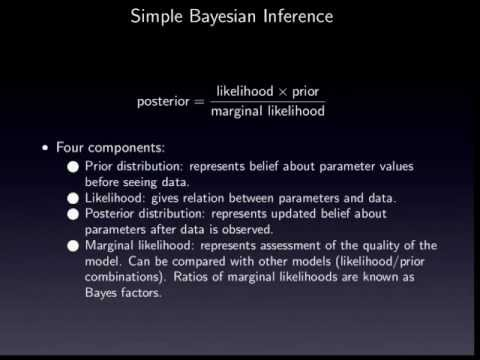

In [20]:
from datetime import timedelta
start=int(timedelta(hours=0, minutes=0, seconds=15).total_seconds())
YouTubeVideo('AvlnFnvFw_0',start=start)


### Multivariate Bayesian Inference (*derivations are <span style="color:red">optional</span>*)

This section of the lecture talks about how we extend the idea of Bayesian inference for the multivariate case. It goes through the multivariate Gaussian and how to complete the square in the linear algebra as we managed below.

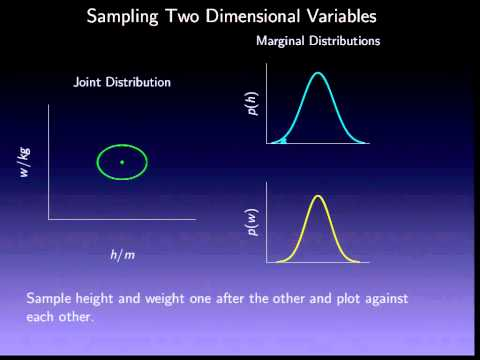

In [21]:
start=int(timedelta(hours=0, minutes=22, seconds=42).total_seconds())
YouTubeVideo('Os1iqgpelPw', start=start)

Compute the posterior distribution for multivariate $\mappingVector$, i.e., the posterior mean and *covariance*. This distribution is also Gaussian,

$$p(\mappingVector | \dataVector, \inputVector, \dataStd^2) = \mathcal{N}\left(\mappingVector|\meanVector_\mappingScalar, \covarianceMatrix_\mappingScalar\right)$$

with covariance, $\covarianceMatrix_\mappingScalar$, given by

$$\covarianceMatrix_\mappingScalar = \left(\dataStd^{-2}\basisMatrix^\top \basisMatrix + \alpha^{-1} \eye\right)^{-1}$$ 

whilst the mean is given by

$$\meanVector_\mappingScalar = \covarianceMatrix_\mappingScalar \dataStd^{-2}\basisMatrix^\top \dataVector$$

Let's compute the posterior covariance and mean, then we'll sample from these densities to have a look at the posterior belief about $\mappingVector$ once the data has been accounted for. 


### Assignment Question 1

Compute the covariance for $\mathbf{w}$ given the training data (using the formulae above) and call the resulting variable `w_cov`. Compute the mean for $\mathbf{w}$ given the training data (using the formulae above) and call the resulting variable `w_mean`. Assume that $\sigma^2 = 0.01$

*10 marks*

In [80]:
# Question 1 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

import numpy as np
sigma2 = 0.01
I = np.identity(6)
w_cov = np.linalg.inv(sigma2**(-1)*(np.matmul(Phi.T, Phi)) + (alpha**(-1)*I))
term1 = w_cov*(sigma2**(-1))
term2 = np.matmul(Phi.T, y)
w_mean = np.matmul(term1, term2)
print('The covariance for w is \n', w_cov)
print('\n')
print('The mean for w is \n', w_mean)

The covariance for w is 
 [[ 1.06158704e-03 -4.37446768e-04 -8.35935773e-03  1.87263818e-03
   1.32164027e-02  3.16540437e-04]
 [-4.37446768e-04  1.75689126e-02 -1.45601515e-03 -7.63863784e-02
   2.29425479e-02  3.09579142e-02]
 [-8.35935773e-03 -1.45601515e-03  1.47248898e-01  5.70950610e-03
  -3.71821930e-01  2.39522296e-02]
 [ 1.87263818e-03 -7.63863784e-02  5.70950610e-03  5.06516468e-01
  -1.12213516e-01 -5.65783208e-01]
 [ 1.32164027e-02  2.29425479e-02 -3.71821930e-01 -1.12213516e-01
   1.24899898e+00 -1.84517863e-01]
 [ 3.16540437e-04  3.09579142e-02  2.39522296e-02 -5.65783208e-01
  -1.84517863e-01  1.66648152e+00]]


The mean for w is 
 [[ 3.37086868]
 [-1.12665201]
 [ 1.60316386]
 [-1.32383453]
 [ 0.54615018]
 [-0.14329519]]


### Sampling from the Posterior

Before we were able to sample the prior values for the mean *independently* from a Gaussian using `np.random.normal` and scaling the result. However, observing the data *correlates* the parameters. Recall this from the first lab where we had a correlation between the offset, $c$ and the slope $m$ which caused such problems with the coordinate ascent algorithm. We need to sample from a *correlated* Gaussian. For this we can use `np.random.multivariate_normal`.

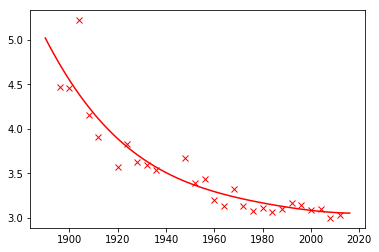

In [83]:
w_sample = np.random.multivariate_normal(w_mean.flatten(), w_cov)
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')
plt.plot(x, y, 'rx') # plot data to show fit.

Now let's sample several functions and plot them all to see how the predictions fluctuate.

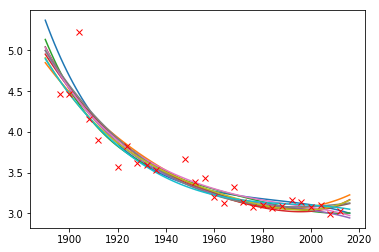

In [84]:
for i in range(num_samples):
    w_sample = np.random.multivariate_normal(w_mean.flatten(), w_cov)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())
plt.plot(x, y, 'rx') # plot data to show fit.

This gives us an idea of what our predictions are. These are the predictions that are consistent with data and our prior. Try plotting different numbers of predictions. You can also try plotting beyond the range of where the data is and see what the functions do there. 

Rather than sampling from the posterior each time to compute our predictions, it might be better if we just summarised the predictions by the expected value of the output funciton, $f(x)$, for any particular input. If we can get formulae for this we don't need to sample the values of $f(x)$ we might be able to compute the distribution directly. Fortunately, in the Gaussian case, we can use properties of multivariate Gaussians to compute both the mean and the variance of these samples.

## Properties of Gaussian Variables

Gaussian variables have very particular properties, that many other densities don't exhibit. Perhaps foremost amoungst them is that the sum of any Gaussian distributed set of random variables also turns out to be Gaussian distributed. This property is much rarer than you might expect.

### Sum of Gaussian-distributed Variables

The sum of Gaussian random variables is also Gaussian, so if we have a random variable $y_i$ drawn from a Gaussian density with mean $\meanScalar_i$ and variance $\dataStd^2_i$, 

$$y_i \sim \gaussianSamp{\meanScalar_i}{\dataStd^2_i}$$

Then the sum of $K$ independently sampled values of $y_i$ will be drawn from a Gaussian with mean $\sum_{i=1}^K \mu_i$ and variance $\sum_{i=1}^K \dataStd_i^2$,


$$\sum_{i=1}^K y_i \sim \gaussianSamp{\sum_{i=1}^K \meanScalar_i}{\sum_{i=1}^K \dataStd_i^2}.$$

Let's try that experimentally. First let's generate a vector of samples from a standard normal distribution, $z \sim \gaussianSamp{0}{1}$,  then we will scale and offset them, then keep adding them into a vector `y_vec`.

#### Sampling from Gaussians and Summing Up

In [85]:
K = 10 # how many Gaussians to add.
num_samples = 1000 # how many samples to have in y_vec
mus = np.linspace(0, 5, K) # mean values generated linearly spaced between 0 and 5
sigmas = np.linspace(0.5, 2, K) # sigmas generated linearly spaced between 0.5 and 2
y_vec = np.zeros(num_samples)
for mu, sigma in zip(mus, sigmas):
    z_vec = np.random.normal(size=num_samples) # z is from standard normal
    y_vec += z_vec*sigma + mu # add to y z*sigma + mu

# now y_vec is the sum of each scaled and off set z.
print('Sample mean is ', y_vec.mean(), ' and sample variance is ', y_vec.var())
print('True mean should be ', mus.sum())
print('True variance should be ', (sigmas**2).sum(), ' standard deviation ', np.sqrt((sigmas**2).sum())) 

Sample mean is  24.92662978957509  and sample variance is  18.13159365383318
True mean should be  25.0
True variance should be  17.916666666666664  standard deviation  4.232808366400098


Of course, we can histogram `y_vec` as well.

C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


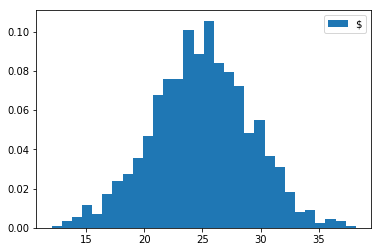

In [86]:
plt.hist(y_vec, bins=30, normed=True)
plt.legend('$y$')

### Matrix Multiplication of Gaussian Variables

We are interested in what our model is saying about the sort of functions we are observing. The fact that summing of Gaussian variables leads to new Gaussian variables, and scaling of Gaussian variables *also* leads to Gaussian variables means that matrix multiplication (which is just a series of sums and scales) also leads to Gaussian densities. Matrix multiplication is just adding and scaling together, in the formula, $\mappingFunctionVector = \basisMatrix \mappingVector$ we can extract the first element from $\mappingFunctionVector$ as

$$\mappingFunctionScalar_i = \basisVector_i^\top \mappingVector$$

where $\basisVector$ is a column vector from the $i$th row of $\basisMatrix$ and $\mappingFunctionScalar_i$ is the $i$th element of $\mappingFunctionVector$. This vector inner product itself merely implies that 

$$\mappingFunctionScalar_i = \sum_{j=1}^K \mappingScalar_j \basisScalar_{i, j}$$

and if we now say that $\mappingScalar_i$ is Gaussian distributed, then because a scaled Gaussian is also Gaussian, and because a sum of Gaussians is also Gaussian, we know that $\mappingFunctionScalar_i$ is also Gaussian distributed. It merely remains to work out its mean and covariance. The results are below and the derviations follow. You need the results to work out the assignment while the derivations are <span style="color:red">*optional*</span> and only for your interest and information.

The expectation under the prior is given by

$$\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\zerosVector}{\alpha\eye}} = \zerosVector$$

and the covariance is 

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\zerosVector}{\alpha \eye}} = \alpha \basisMatrix \basisMatrix^\top$$

### Derivations of the mean and covariance of $\mappingFunctionVector$ (<span style="color:red">*optional*</span>)

We can do this by looking at the expectation under a Gaussian distribution. The expectation of the mean vector is given by

$$\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \int \mappingFunctionVector \gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix} \text{d}\mappingVector = \int \basisMatrix\mappingVector \gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix} \text{d}\mappingVector = \basisMatrix \int \mappingVector \gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix} \text{d}\mappingVector = \basisMatrix \meanVector$$

Which is straightforward. The expectation of $\mappingFunctionVector=\basisMatrix\mappingVector$ under the Gaussian distribution for $\mappingFunctionVector$ is simply $\mappingFunctionVector=\basisMatrix\meanVector$, where $\meanVector$ is the *mean* of the Gaussian density for $\mappingVector$. Because our prior distribution was Gaussian with zero mean, the expectation under the prior is given by

$$\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\zerosVector}{\alpha\eye}} = \zerosVector$$

The covariance is a little more complicated. A covariance matrix is defined as

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \expDist{\mappingFunctionVector\mappingFunctionVector^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} - \expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}}\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}}^\top$$

we've already computed $\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}}=\basisMatrix \meanVector$ so we can substitute that in to recover

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \expDist{\mappingFunctionVector\mappingFunctionVector^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} - \basisMatrix \meanVector \meanVector^\top \basisMatrix^\top$$

So we need the expectation of $\mappingFunctionVector\mappingFunctionVector^\top$. Substituting in $\mappingFunctionVector = \basisMatrix \mappingVector$ we have

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \expDist{\basisMatrix\mappingVector\mappingVector^\top \basisMatrix^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} - \basisMatrix \meanVector \meanVector^\top \basisMatrix^\top$$

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \basisMatrix\expDist{\mappingVector\mappingVector^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} \basisMatrix^\top - \basisMatrix \meanVector \meanVector^\top \basisMatrix^\top$$

Which is dependent on the second moment of the Gaussian,

$$\expDist{\mappingVector\mappingVector^\top}{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \covarianceMatrix + \meanVector\meanVector^\top$$

that can be substituted in to recover,

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \basisMatrix\covarianceMatrix \basisMatrix^\top$$

so in the case of the prior distribution, where we have $\covarianceMatrix = \alpha \eye$ we can write

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\zerosVector}{\alpha \eye}} = \alpha \basisMatrix \basisMatrix^\top$$

This implies that the prior we have suggested for $\mappingVector$, which is Gaussian with a mean of zero and covariance of $\alpha \eye$ suggests that the distribution for $\mappingFunctionVector$ is also Gaussian with a mean of zero and covariance of $\alpha \basisMatrix\basisMatrix^\top$. 

### Compute the Marginal Likelihood

Since our observed output, $\dataVector$, is given by a noise corrupted variation of $\mappingFunctionVector$, the final distribution for $\dataVector$ is given as 

$$\dataVector = \mappingFunctionVector + \noiseVector$$

where the noise, $\noiseVector$, is sampled from a Gaussian density: $\noiseVector \sim \gaussianSamp{\zerosVector}{\dataStd^2\eye}$. So, in other words, we are taking a Gaussian distributed random value $\mappingFunctionVector$,

$$\mappingFunctionVector \sim \gaussianSamp{\zerosVector}{\alpha\basisMatrix\basisMatrix^\top}$$

and adding to it another Gaussian distributed value, $\noiseVector \sim \gaussianSamp{\zerosVector}{\dataStd^2\eye}$, to form our data observations, $\dataVector$. Once again the sum of two (multivariate) Gaussian distributed variables is also Gaussian, with a mean given by the sum of the means (both zero in this case) and the covariance given by the sum of the covariances. So we now have that the marginal likelihood for the data, $p(\dataVector)$ is given by

$$p(\dataVector) = \gaussianDist{\dataVector}{\zerosVector}{\alpha \basisMatrix \basisMatrix^\top + \dataStd^2\eye}$$

This is our *implicit* assumption for $\dataVector$ given our prior assumption for $\mappingVector$.

### Computing the Mean and Error Bars of the Functions

These ideas together, now allow us to compute the mean and error bars of the predictions. The mean prediction, before corrupting by noise is given by,
$$
\mathbf{f} = \boldsymbol{\Phi}\mathbf{w}
$$
in matrix form. This gives you enough information to compute the predictive mean. 

### Assignment Question 2

Compute the predictive mean for the function at all the values of the basis function given by `Phi_pred`. Call the vector of predictions `f_pred_mean`. Plot the predictions alongside the data. We can also compute what the training error was. Use the output from your model to compute the predictive mean, and then compute the sum of squares error of that predictive mean.
$$
E = \sum_{i=1}^n (y_i - \langle f_i\rangle)^2
$$
where $\langle f_i\rangle$ is the expected output of the model at point $x_i$.

*15 marks*

The error is:  1.0836499587947628


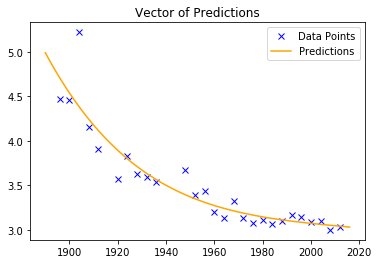

In [87]:
# Question 2 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

f_pred_mean = np.matmul(Phi_pred, w_mean)
# plot the predictions
plt.plot(x, y, 'bx', label = 'Data Points')
plt.plot(x_pred, f_pred_mean, 'orange', label = 'Predictions')
plt.title("Vector of Predictions", loc='center')
plt.legend()
plt.plot() 
# compute mean at the training data and sum of squares error
f_mean = np.matmul(Phi, w_mean)
error = y - f_mean
sum_squares = np.square(error).sum()
print('The error is: ', sum_squares)

### Computing Error Bars

Finally, we can compute error bars for the predictions. The error bars are the standard deviations of the predictions for $\mappingFunctionVector=\basisMatrix\mappingVector$ under the posterior density for $\mappingVector$. The standard deviations of these predictions can be found from the variance of the prediction at each point. Those variances are the diagonal entries of the covariance matrix. We've already computed the form of the covariance under Gaussian expectations, 

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \basisMatrix\covarianceMatrix \basisMatrix^\top$$

which under the posterior density is given by

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector_w}{\covarianceMatrix_w}} = \basisMatrix\covarianceMatrix_w \basisMatrix^\top$$

### Assignment Question 3

The error bars are given by computing the standard deviation of the predictions, $f$. For a given prediction $f_i$ the variance is $\text{var}(f_i) = \langle f_i^2\rangle - \langle f_i \rangle^2$. This is given by the diagonal element of the covariance of $\mathbf{f}$,
$$
\text{var}(f_i) = \boldsymbol{\phi}_{i, :}^\top \mathbf{C}_w \boldsymbol{\phi}_{i, :}
$$
where $\boldsymbol{\phi}_{i, :}$ is the basis vector associated with the input location, $\mathbf{x}_i$.

Plot the mean function and the error bars for your basis.

*20 marks*


[]

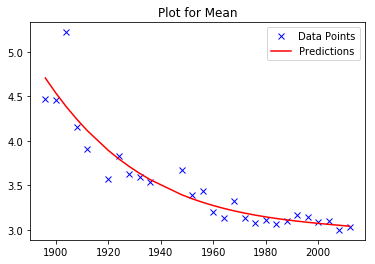

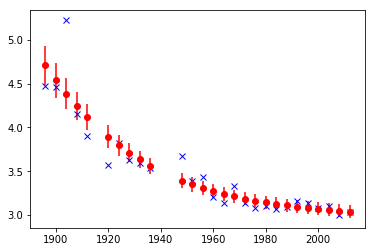

In [97]:
# Question 3 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

# Compute variance at function values
f_pred_var = [] # initialising f_pred_var
f_pred_std = [] # initialising f_pred_std
n = x.shape[0] # taking the length of x for iteration
for i in range(n):
    term3 = np.matmul(Phi_pred[i].T, w_cov)
    fpredvar = np.matmul(term3, Phi_pred[i])
    f_pred_var = np.append(f_pred_var,fpredvar)
    f_pred_std = np.sqrt(f_pred_var)

#plot the mean and error bars at 2 standard deviations above and below the mean

plt.plot(x, y, 'bx', label = 'Data Points')
plt.plot(x, f_mean, 'red', label = 'Predictions')
plt.title("Plot for Mean", loc='center')
plt.legend()
plt.plot() 

plt.figure()
yerr = 2*f_pred_std
plt.errorbar(x.flatten(), f_mean.flatten(), yerr, fmt = 'o', c = 'red')
plt.plot(x, y, 'bx')
plt.plot() 


### Validation

Now we will test the generalisation ability of these models. Firstly we are going to use hold out validation to attempt to see which model is best for extrapolating.

### Assignment Question 4

Now split the data into training and *hold out* validation sets. Hold out the data for years after 1980. Compute the predictions for different model orders between 0 and 8. Find the model order which fits best according to *hold out* validation. Is it the same as the maximum likelihood result fom last week?

*25 marks*

In [34]:
# Question 4 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

import numpy as np

# select indices of data to 'hold out'
indices_hold_out = np.flatnonzero(x>1980)

# Create a training set
x_train = np.delete(x, indices_hold_out, axis=0)
y_train = np.delete(y, indices_hold_out, axis=0)

# Create a hold out set
x_valid = np.take(x, indices_hold_out, axis=0)
y_valid = np.take(y, indices_hold_out, axis=0)

errorval = []
for i in range(9):
    Phi_train = polynomial(x_train, degree=i, loc=1956, scale=120) # value of phi for training
    Phi_valid = polynomial(x_valid, degree=i, loc=1956, scale=120) # value of phi for validation
    I = np.identity(Phi_train.shape[1])
    w_cov = np.linalg.inv(sigma2**(-1)*(np.matmul(Phi_train.T, Phi_train)) + (alpha**(-1)*I))
    term1 = w_cov*(sigma2**(-1))
    term2 = np.matmul(Phi_train.T, y_train)
    w_mean = np.matmul(term1, term2)
    f_valid = np.dot(Phi_valid, w_mean)
    e1 = y_valid - f_valid
    err = np.square(e1).sum()
    print('The error is', err, 'for the iteration', i)
    errorval = np.append(errorval, err)

The error is 2.8041757997348267 for the iteration 0
The error is 1.8847258481294618 for the iteration 1
The error is 0.13892017158426867 for the iteration 2
The error is 0.05110063975445037 for the iteration 3
The error is 0.0438697992377525 for the iteration 4
The error is 0.04839901725202888 for the iteration 5
The error is 0.048325602600050296 for the iteration 6
The error is 0.04835634608604622 for the iteration 7
The error is 0.04835646467341541 for the iteration 8


In [35]:
error_valid_min = min(errorval)
error_valid_min_poly=list(errorval).index(error_valid_min) # finding the degree of the polynomial
print('The degree of polynomial with the lowest validation error is', error_valid_min_poly)
print('Hence, it best fits the hold out validation.')

The degree of polynomial with the lowest validation error is 4
Hence, it best fits the hold out validation.


#### Question 4 Answer

No, it is not same as that of last week, for which we got a polynomial of degree 2, because the value of $\mappingVector$ was being calculated through QR decomposition earlier, but now, we are applying Bayesian Approach to calculate $\mappingVector$.

### Assignment Question 5

Now we will use leave one out cross validation to attempt to see which model is best at interpolating. Do you get the same result as for hold out validation? Compare plots of the hold out validation area for different degrees and the cross validation error for different degrees. Why are they so different? Select a suitable polynomial for characterising the differences in the predictions. Plot the mean function and the error bars for the full data set (to represent the leave one out solution) and the training data from the hold out experiment. Discuss your answer. 

*30 marks*

In [37]:
# Question 5 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

leave_one_out_pred =  [] # initialising a variable for our leave-one-out prediction

range_poly = 9 # setting our range
n = x.shape[0]
for k in range(range_poly):
    err_leave_one_out = []
    for m in range(n):
        # Create a training set
        x_train_lo = np.delete(x, m, axis=0)
        y_train_lo = np.delete(y, m, axis=0)

        # Create a validation set
        x_valid_lo = np.take(x, m, axis=0)
        y_valid_lo = np.take(y, m, axis=0)
        
        Phi_train_lo = polynomial(x_train_lo, degree=k, loc=1956, scale=120)
        Phi_valid_lo = polynomial(x_valid_lo, degree=k, loc=1956, scale=120)
        I = np.identity(Phi_train_lo.shape[1])
        w_cov_lo = np.linalg.inv(sigma2**(-1)*(np.matmul(Phi_train_lo.T, Phi_train_lo)) + (alpha**(-1)*I))
        term1_lo = w_cov_lo*(sigma2**(-1))
        term2_lo = np.matmul(Phi_train_lo.T, y_train_lo)
        w_mean_lo = np.matmul(term1_lo, term2_lo)
        f_valid_lo = np.dot(Phi_valid_lo, w_mean_lo)
        er_lo = y_valid_lo - f_valid_lo
        e_lo = np.square(er_lo).sum()
        err_leave_one_out = np.append(err_leave_one_out, e_lo) # has 27 values
    err_leave_one_out_sum = np.sum(err_leave_one_out) # adding 27 errors
    err_leave_one_out_avg = err_leave_one_out_sum/n # avg of 27 errors for the polynomial
    print('The leave one out error value is', err_leave_one_out_avg, 'for degree', k)
    leave_one_out_pred = np.append(leave_one_out_pred, err_leave_one_out_avg) 


The leave one out error value is 0.3084179186825952 for degree 0
The leave one out error value is 0.09060443120649114 for degree 1
The leave one out error value is 0.05774167370182921 for degree 2
The leave one out error value is 0.05742507042115905 for degree 3
The leave one out error value is 0.05801983890244341 for degree 4
The leave one out error value is 0.05823090656361795 for degree 5
The leave one out error value is 0.05832074419154137 for degree 6
The leave one out error value is 0.058345913253669994 for degree 7
The leave one out error value is 0.0583534416116385 for degree 8


In [39]:
leave_one_out_pred_min = min(leave_one_out_pred)
leave_one_out_pred_poly=list(leave_one_out_pred).index(leave_one_out_pred_min)
print('The degree of polynomial with the lowest validation error is', leave_one_out_pred_poly, '.')
print('Hence it is the best at interpolating. This is not the same when compared to hold out validation, for which, it was 4.')

The degree of polynomial with the lowest validation error is 3 .
Hence it is the best at interpolating. This is not the same when compared to hold out validation, for which, it was 4.


The error difference is [ 2.49575788  1.79412142  0.0811785  -0.00632443 -0.01415004 -0.00983189
 -0.00999514 -0.00998957 -0.00999698]
The difference of w_mean is [[ 0.00174043]
 [-0.06542185]
 [-0.2578238 ]
 [-0.15618837]
 [ 0.1046071 ]
 [ 0.00700176]
 [ 0.04571231]
 [ 0.00684971]
 [ 0.0123548 ]]


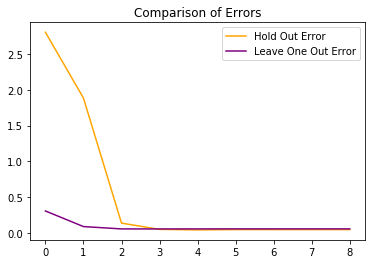

In [55]:
# plotting the errors
plt.plot(errorval, 'orange', label = 'Hold Out Error')
plt.plot(leave_one_out_pred, 'purple', label = 'Leave One Out Error')
plt.title("Comparison of Errors", loc='center')
plt.legend()
plt.plot() 

# finding out the error difference and w_mean difference for both the cases
print('The error difference is', errorval - leave_one_out_pred)
print('The difference of w_mean is', w_mean - w_mean_lo)


#### Question 5 Answer

We can see that there is an error diference between hold out validation and leave one out for each degree. This is because the value of w_mean changes for both the validations since the values of training data sets of x and y change, for which the value of Phi gets changed. This changes the prediction function and as a result, the error changes.

In [41]:
deg = 6 # selecting a particular polynomial degree

Phi_train_deg = polynomial(x, degree = deg, loc = 1956, scale = 120)
I = np.identity(Phi_train_deg.shape[1])
w_cov_deg = np.linalg.inv(sigma2**(-1)*(np.matmul(Phi_train_deg.T, Phi_train_deg)) + (alpha**(-1)*I))
term1_deg = w_cov_deg*(sigma2**(-1))
term2_deg = np.matmul(Phi_train_deg.T, y)
w_mean_deg = np.matmul(term1_deg, term2_deg)
f_mean_deg = np.dot(Phi_train_deg, w_mean_deg)

[]

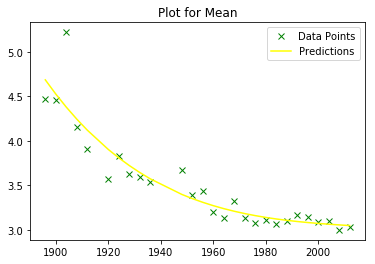

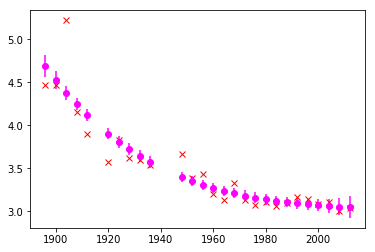

In [95]:
# Compute variance at function values
f_pred_var_deg = []
f_pred_std_deg = []
n = x.shape[0]
for i in range(n):
    term4 = np.matmul(Phi_train_deg[i].T, w_cov_deg)
    fpredvardeg = np.matmul(term4, Phi_train_deg[i])
    f_pred_var_deg = np.append(f_pred_var_deg,fpredvardeg)
    f_pred_std_deg = np.sqrt(f_pred_var_deg)

# plotting the mean and error bars at 2 standard deviations above and below the mean

plt.plot(x, y, 'gx', label = 'Data Points')
plt.plot(x, f_mean_deg, 'yellow', label = 'Predictions')
plt.title("Plot for Mean", loc='center')
plt.legend()
plt.plot() 

plt.figure()
yerr = 2*f_pred_std_deg
plt.errorbar(x.flatten(), f_mean_deg.flatten(), yerr, fmt = 'o', c = 'magenta')
plt.plot(x, y, 'rx')
plt.plot() 



In [50]:
deg = 6 # selecting a particular polynomial degree

Phi_train_deg_t = polynomial(x_train, degree = deg, loc = 1956, scale = 120)
I = np.identity(Phi_train_deg_t.shape[1])
w_cov_deg_t = np.linalg.inv(sigma2**(-1)*(np.matmul(Phi_train_deg_t.T, Phi_train_deg_t)) + (alpha**(-1)*I))
term1_deg_t = w_cov_deg_t*(sigma2**(-1))
term2_deg_t = np.matmul(Phi_train_deg_t.T, y_train)
w_mean_deg_t = np.matmul(term1_deg_t, term2_deg_t)
f_mean_deg_t = np.dot(Phi_train_deg_t, w_mean_deg_t)

[]

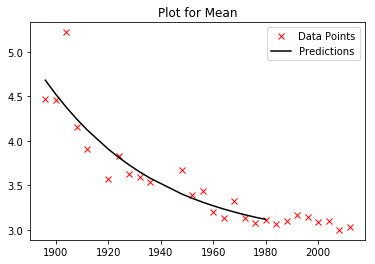

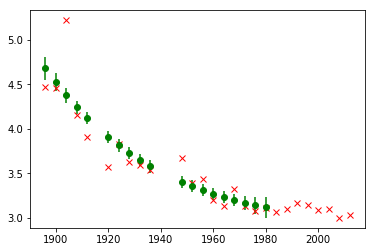

In [99]:
# Compute variance at function values
f_pred_var_deg_t = []
f_pred_std_deg_t = []
n = x_train.shape[0]
for i in range(n):
    term5 = np.matmul(Phi_train_deg_t[i].T, w_cov_deg_t)
    fpredvardegt = np.matmul(term5, Phi_train_deg_t[i])
    f_pred_var_deg_t = np.append(f_pred_var_deg_t,fpredvardegt)
    f_pred_std_deg_t = np.sqrt(f_pred_var_deg_t)

# plotting the mean and error bars at 2 standard deviations above and below the mean

plt.plot(x, y, 'rx', label = 'Data Points')
plt.plot(x_train, f_mean_deg_t, 'black', label = 'Predictions')
plt.title("Plot for Mean", loc='center')
plt.legend()
plt.plot() 

plt.figure()
yerr = 2*f_pred_std_deg_t
plt.errorbar(x_train.flatten(), f_mean_deg_t.flatten(), yerr, fmt = 'o', c = 'green')
plt.plot(x, y, 'rx')
plt.plot() 


There is a difference in plots because of the difference in the number of data points. The full data set has 27 data points whereas, the training data has 19. This changes the value of Phi.